In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import hcpdatautils as hcp
import isingutils as ising
import math
import time

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
data_dir = 'E:\\HCP_data'
model_dir = 'E:\\Ising_model_results_daai'
stats_dir = 'E:\\Ising_model_results_daai'

In [4]:
subjects = hcp.get_has_sc_subject_list( directory_path=data_dir, subject_list=hcp.load_training_subjects(data_dir) )
num_subjects = len(subjects)
print(f'loaded {num_subjects} subject IDs')

loaded 669 subject IDs


In [5]:
num_nodes = hcp.num_brain_areas
with torch.no_grad():
    sc = torch.zeros( (num_subjects, num_nodes, num_nodes), dtype=float_type, device=device )
    for subject_index in range(num_subjects):
        subject_id = subjects[subject_index]
        sc_file = hcp.get_structural_connectivity_file_path(directory_path=data_dir, subject_id=subject_id)
        sc[subject_index,:,:] = hcp.load_matrix_from_binary(file_path=sc_file, dtype=float_type, device=device)
print( 'sc size ', sc.size() )

sc size  torch.Size([669, 360, 360])


In [6]:
sc_mean = torch.mean(sc, dim=0)
sc_is_nonzero = sc_mean != 0
num_sc_nonzero = torch.count_nonzero(sc_is_nonzero)
num_sc = torch.numel(sc_is_nonzero)
print(f'{num_sc_nonzero} out of {num_sc}, {100*num_sc_nonzero/num_sc:.3g} percent, are non-0')

129240 out of 129600, 99.7 percent, are non-0


In [7]:
num_sc_nonzero = torch.count_nonzero(sc)
num_sc = torch.numel(sc)
print(f'{num_sc_nonzero} out of {num_sc}, {100*num_sc_nonzero/num_sc:.3g} percent, are non-0')

78348836 out of 86702400, 90.4 percent, are non-0


In [8]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.25, 0.5, 0.75, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[2].item():.3g} with interquartile range [{quantiles[1].item():.3g}, {quantiles[-2].item():.3g}], 95% CI [{quantiles[0].item():.3g}, {quantiles[-1].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

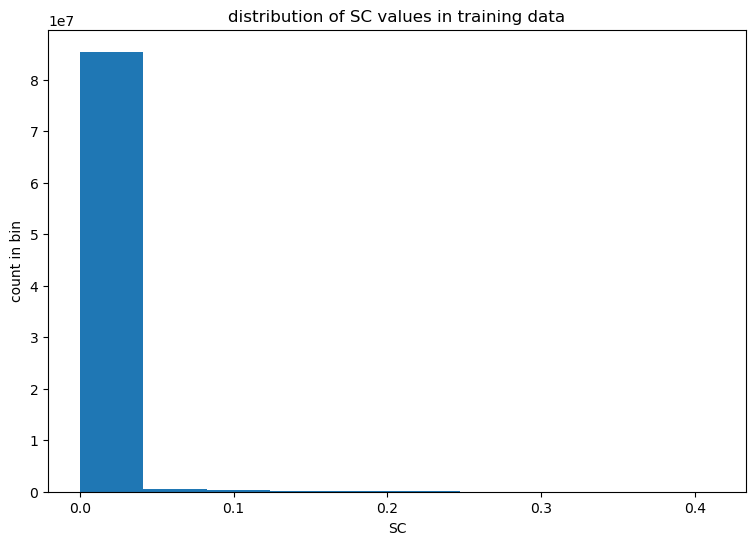

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.hist( sc.flatten().detach().cpu().numpy() )
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('SC')
axs.set_ylabel('count in bin')
axs.set_title('distribution of SC values in training data')
plt.show()
# print_stats('SC', sc)

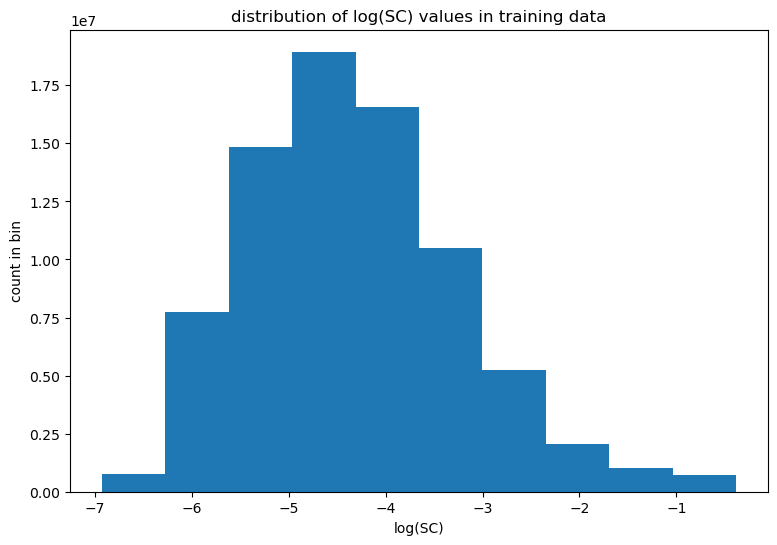

In [10]:
sc_is_nonzero = sc != 0
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.hist(  torch.log10( sc[sc_is_nonzero] ).flatten().detach().cpu().numpy()  )
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('log(SC)')
axs.set_ylabel('count in bin')
axs.set_title('distribution of log(SC) values in training data')
plt.show()

In [11]:
min_sc = sc.min()
median_sc = sc.median()
max_sc = sc.max()
print(f'SC min {min_sc:.3g}, median {median_sc:.3g}, max {max_sc:.3g}')

SC min 0, median 2.76e-05, max 0.412


In [12]:
nzsc = sc[sc_is_nonzero]
min_nzsc = nzsc.min()
median_nzsc = nzsc.median()
max_nzsc = nzsc.max()
print(f'non-0 SC min {min_nzsc:.3g}, median {median_nzsc:.3g}, max {max_nzsc:.3g}')

non-0 SC min 1.19e-07, median 3.83e-05, max 0.412


In [13]:
subject_index = 0
subject_id = subjects[subject_index]
subject_sc = sc[subject_index,:,:]
subject_median_sc = subject_sc.median()
subject_mask = (subject_sc >= subject_median_sc).float().unsqueeze(dim=0)
subject_num_edges = torch.count_nonzero(subject_mask)
subject_mask_size = subject_mask.numel()
print(f'{subject_num_edges} out of {subject_mask_size} edges, {100*subject_num_edges/subject_mask_size:.3g} percent, have SC above the median, {subject_median_sc:.3g}')

64802 out of 129600 edges, 50 percent, have SC above the median, 3.37e-05


In [14]:
subject_ts = hcp.load_all_time_series_for_subject(directory_path=data_dir, subject_id=subject_id, dtype=float_type, device=device)
subject_ts = ising.standardize_and_binarize_ts_data(ts=subject_ts).flatten(start_dim=0, end_dim=-2).unsqueeze(dim=0)
print( 'binarized and concatenated subject ts size', subject_ts.size() )

binarized and concatenated subject ts size torch.Size([1, 4800, 360])


In [15]:
subject_fc = hcp.get_fc_batch(subject_ts)
print( 'FC size', subject_fc.size() )

FC size torch.Size([1, 360, 360])


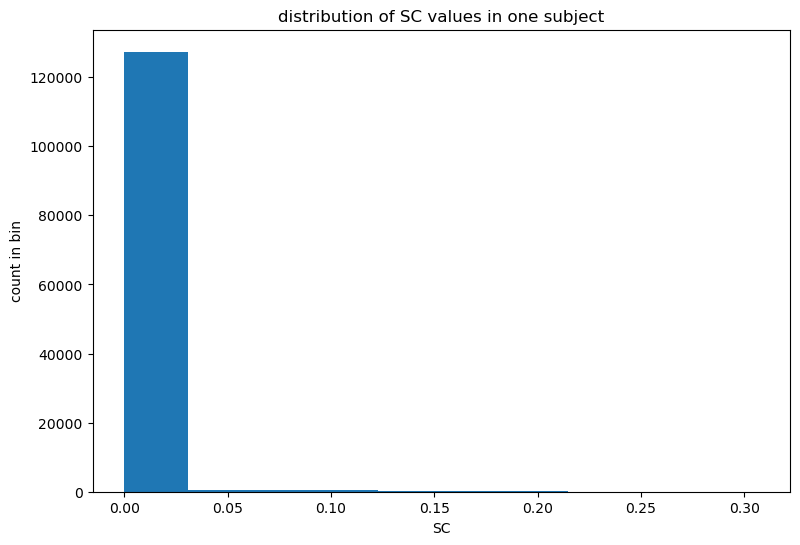

The distribution of SC values has median 3.37e-05 with interquartile range [5.78e-06, 0.000192], 95% CI [0, 0.0128] and range [0, 0.307].


In [16]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.hist( subject_sc.abs().flatten().detach().cpu().numpy() )
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('SC')
axs.set_ylabel('count in bin')
axs.set_title('distribution of SC values in one subject')
plt.show()
print_stats( 'SC', subject_sc.abs() )

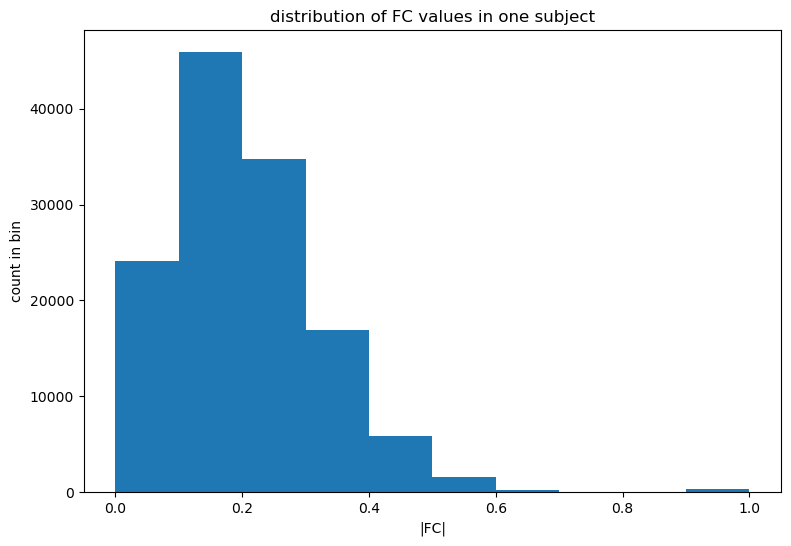

The distribution of |FC| values has median 0.188 with interquartile range [0.12, 0.273], 95% CI [0.0207, 0.47] and range [3.96e-06, 1].


In [17]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.hist( subject_fc.abs().flatten().detach().cpu().numpy() )
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('|FC|')
axs.set_ylabel('count in bin')
axs.set_title('distribution of FC values in one subject')
plt.show()
print_stats( '|FC|', subject_fc.abs() )

In [18]:
with torch.no_grad():
    beta = 0.5
    batch_size, num_steps, num_nodes = subject_ts.size()
    J, h, s = ising.get_batched_ising_models(batch_size=batch_size, num_nodes=num_nodes, dtype=float_type, device=device)
    print( 'J size', J.size() )
    print( 'h size', h.size() )
    print( 's size', s.size() )
    epoch = 1
    delta_J = torch.zeros_like(J)
    delta_h = torch.zeros_like(h)
    # Mask the initial J values.
    J *= subject_mask
    print( 'num non-0 Js', torch.count_nonzero(J).item() )

J size torch.Size([1, 360, 360])
h size torch.Size([1, 360])
s size torch.Size([1, 360])
num non-0 Js 64802


In [19]:
start_time = time.time()
print('simulating...')
with torch.no_grad():
    sim_fc, s = ising.run_batched_balanced_metropolis_sim_for_fc(J=J, h=h, s=s, num_steps=num_steps, beta=beta)
    fc_rmse = hcp.get_triu_rmse_batch(sim_fc, subject_fc).item()
    fc_corr = hcp.get_triu_corr_batch(sim_fc, subject_fc).item()
elapsed_time = time.time() - start_time
print(f'done, FC correlation {fc_corr:.3g}, FC RMSE {fc_rmse:.3g}, time {elapsed_time:.3g}')

simulating...
done, FC correlation 0.0207, FC RMSE 0.545, time 605


In [20]:
print(  'J NaNs', torch.count_nonzero( torch.isnan(J) ).item()  )
print(  'h NaNs', torch.count_nonzero( torch.isnan(h) ).item()  )
print(  's NaNs', torch.count_nonzero( torch.isnan(s) ).item()  )
print(  'sim_fc NaNs', torch.count_nonzero( torch.isnan(sim_fc) ).item()  )
print(  'subject_fc NaNs', torch.count_nonzero( torch.isnan(subject_fc) ).item()  )

J NaNs 0
h NaNs 0
s NaNs 0
sim_fc NaNs 0
subject_fc NaNs 0


In [23]:
window_length = 50
num_updates = 0
num_epochs = 100
scaled_learning_rate = 0.001
J_file = os.path.join(model_dir, f'h_mask_test_subject_{subject_id}.pt')
h_file = os.path.join(model_dir, f'J_mask_test_subject_{subject_id}.pt')
start_time = time.time()
with torch.no_grad():
    for epoch in range(num_epochs):
        print(f'starting training epoch {epoch}')
        for step in range(num_steps):
            s = ising.run_batched_balanced_metropolis_sim_step(J=J, h=h, s=s, beta=beta)
            d = subject_ts[:,step,:]
            delta_h += (d - s)
            delta_J += (d[:,:,None] * d[:,None,:] - s[:,:,None] * s[:,None,:])
            if (step % window_length) == 0:
                h += scaled_learning_rate * delta_h
                delta_h[:,:] = 0.0
                J += scaled_learning_rate * subject_mask * delta_J
                delta_J[:,:,:] = 0.0
                num_updates += 1
        torch.save(J, J_file)
        torch.save(h, h_file)
        sim_fc, s = ising.run_batched_balanced_metropolis_sim_for_fc(J=J, h=h, s=s, num_steps=num_steps, beta=beta)
        fc_rmse = hcp.get_triu_rmse_batch(sim_fc, subject_fc).item()
        fc_corr = hcp.get_triu_corr_batch(sim_fc, subject_fc).item()
        elapsed_time = time.time() - start_time
        print(f'epoch {epoch}, updates {num_updates}, FC correlation {fc_corr:.3g}, FC RMSE {fc_rmse:.3g}, time {elapsed_time:.3g}')

starting training epoch 0
epoch 0, updates 96, FC correlation 0.0238, FC RMSE 0.576, time 1.25e+03
starting training epoch 1
epoch 1, updates 192, FC correlation -0.0267, FC RMSE 0.465, time 2.5e+03
starting training epoch 2
epoch 2, updates 288, FC correlation 0.0281, FC RMSE 0.404, time 3.75e+03
starting training epoch 3
epoch 3, updates 384, FC correlation 0.0344, FC RMSE 0.437, time 5e+03
starting training epoch 4
epoch 4, updates 480, FC correlation 0.0844, FC RMSE 0.324, time 6.22e+03
starting training epoch 5
epoch 5, updates 576, FC correlation 0.285, FC RMSE 0.303, time 7.43e+03
starting training epoch 6
epoch 6, updates 672, FC correlation 0.0348, FC RMSE 0.424, time 8.65e+03
starting training epoch 7
epoch 7, updates 768, FC correlation -0.00762, FC RMSE 0.429, time 9.88e+03
starting training epoch 8
epoch 8, updates 864, FC correlation 0.0469, FC RMSE 0.386, time 1.11e+04
starting training epoch 9
epoch 9, updates 960, FC correlation 0.0191, FC RMSE 0.464, time 1.23e+04
sta

epoch 80, updates 7776, FC correlation 0.00972, FC RMSE 0.305, time 1.12e+05
starting training epoch 81
epoch 81, updates 7872, FC correlation 0.00393, FC RMSE 0.332, time 1.13e+05
starting training epoch 82
epoch 82, updates 7968, FC correlation 0.078, FC RMSE 0.299, time 1.15e+05
starting training epoch 83
epoch 83, updates 8064, FC correlation -0.00667, FC RMSE 0.38, time 1.16e+05
starting training epoch 84
epoch 84, updates 8160, FC correlation -0.0768, FC RMSE 0.357, time 1.18e+05
starting training epoch 85
epoch 85, updates 8256, FC correlation 0.0583, FC RMSE 0.287, time 1.19e+05
starting training epoch 86
epoch 86, updates 8352, FC correlation -0.0328, FC RMSE 0.414, time 1.21e+05
starting training epoch 87
epoch 87, updates 8448, FC correlation 0.0581, FC RMSE 0.285, time 1.22e+05
starting training epoch 88
epoch 88, updates 8544, FC correlation 0.123, FC RMSE 0.417, time 1.23e+05
starting training epoch 89
epoch 89, updates 8640, FC correlation -0.0235, FC RMSE 0.334, time 1.

In [ ]:
window_length = 50
num_updates = 0
start_time = time.time()
with torch.no_grad():
    print(f'starting training epoch {epoch}')
    for step in range(num_steps):
        s = hcp.run_batched_balanced_metropolis_sim_step(J=J, h=h, s=s, beta=beta)
        d = data_ts[:,step,:]
        delta_h += (d - s)
        delta_J += (d[:,:,None] * d[:,None,:] - s[:,:,None] * s[:,None,:])
        if (step % window_length) == 0:
            h += scaled_learning_rate * delta_h
            delta_h[:,:] = 0.0
            J += scaled_learning_rate * subject_mask * delta_J
            delta_J[:,:,:] = 0.0
            num_updates += 1
elapsed_time = time.time() - start_time
print(f'done, updates {num_updates}, time {elapsed_time:.3g}')